### Experiment 0


The objective with this experiment is to test the pipeline devloped.

In [1]:
# TODOs
# 1. Use fit_generator() instead of generator()
# 2. Use H5py format to store features

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import datetime
import os
import numpy as np
import tensorflow as tf
import keras
import sklearn.model_selection as sk
import copy
from PIL import Image as IM
from keras.callbacks import TensorBoard
import cv2
import json
import pathlib
from glob import glob

Using TensorFlow backend.


In [3]:
## import helpers
from helpers import data_loaders as dls
from helpers import pointcloud as pc
from helpers.viz import plot, plot_history
from helpers.logger import Logger

In [4]:
import lodnn

In [5]:
PATH = '../' # path of the repo.
_NAME = 'experiment0' # name of experiment
!ls $PATH

dataset  nbs  README.md  TODO


In [6]:
# It is better to create a folder with runid in the experiment folder
_EXP, _LOG, _TMP, _RUN_PATH = dls.create_dir_struct(PATH, _NAME)
logger = Logger('EXP0', _LOG + 'experiment0.log')
logger.debug('Logger EXP0 int')
!ls $_EXP

log  tmp


In [7]:
# get dataset
train_set, valid_set, test_set = dls.get_dataset(PATH, is_training=True)

In [8]:
z_vals = dls.process_pc(train_set["pc"] + valid_set["pc"], lambda x: x[:, 2])
z_vals = np.concatenate(z_vals)
HEIGHT_MIN, HEIGHT_MAX = np.min(z_vals), np.max(z_vals)
print("Height ranges from {} to {}".format(HEIGHT_MIN, HEIGHT_MAX))
del z_vals

Height ranges from -30.21500015258789 to 2.9130001068115234


In [9]:
def preprocess(points):
    global HEIGHT_MIN, HEIGHT_MAX
    points = pc.filter_points(points, side_range=(-10, 10), fwd_range=(6, 46))
    z = points[:, 2]
    z_min, z_max = HEIGHT_MIN, HEIGHT_MAX
    z = (z - z_min)/(z_max - z_min)
    points[:, 2] = z
    return points

In [10]:
f_count = dls.process_pc(train_set["pc"] + valid_set["pc"],
                       lambda x: lodnn.get_features(preprocess(x))[:,:,0])

f_count = np.concatenate(f_count)
COUNT_MIN, COUNT_MAX = 0, np.max(f_count)
print("Count varies from {} to {}".format(COUNT_MIN, COUNT_MAX))
del f_count

Count varies from 0 to 122.0


#### Get dataset

In [11]:
def _get_features(points):
    global COUNT_MAX
    f = lodnn.get_features(preprocess(points))
    f[:, :, 0] = f[:, :, 0] / COUNT_MAX
    return f

In [12]:
def kitti_gt(img):
    road = img[:, :, 0] / 255 # Road is encoded as 255 in the B plane
    non_road = 1 - road # TODO: can we do this in training time?
    return np.dstack([road, non_road])

In [13]:
limit_index = 6
# NOTE: change limit_index to -1 to train on the whole dataset
f_train = dls.process_pc(train_set["pc"][0:limit_index], lambda x: _get_features(x))
f_valid = dls.process_pc(valid_set["pc"][0:limit_index], lambda x: _get_features(x))
f_test = dls.process_pc(test_set["pc"][0:limit_index], lambda x: _get_features(x))
gt_train = dls.process_img(train_set["gt_bev"][0:limit_index], func=lambda x: kitti_gt(x))
gt_valid = dls.process_img(valid_set["gt_bev"][0:limit_index], func=lambda x: kitti_gt(x))
gt_test = dls.process_img(train_set["gt_bev"][0:limit_index], func=lambda x: kitti_gt(x))

In [14]:
# _ = plot([[f_train[0][:,:,0], f_train[1][:,:,0],  f_train[2][:,:,0]],
#       [f_train[0][:,:,1], f_train[1][:,:,1],  f_train[2][:,:,1]],
#       [gt_train[0][:,:,0], gt_train[1][:,:,0], gt_train[1][:,:,0]]
#      ])

#### Let the training begin

In [15]:
def get_unique_id():
    return datetime.datetime.today().strftime('%Y_%m_%d_%H_%M')

In [16]:
def create_run_dir(path, run_id):
    path = path.replace("*run_id", str(run_id))
    model_dir = "{}/model/".format(path)
    output_dir = "{}/output/".format(path)
    log_dir = "{}/log/".format(path)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    return path

In [17]:
def get_basic_callbacks(path):
    # tensorboard
    # to visualise `tensorboard --logdir="./path_to_log_dir" --port 6006`
    log_path = "{}/log/".format(path)
    tensorboard = TensorBoard(log_dir="{}/{}".format(log_path, time()))
    # save best model
    best_model_path = "{}/model/best_model.h5".format(path) #? .hd5
    save_the_best = keras.callbacks.ModelCheckpoint(filepath=best_model_path,
                                                    verbose=1, save_best_only=True)
    # save models after few epochs
    epoch_save_path = "{}/model/*.h5".format(path)
    save_after_epoch = keras.callbacks.ModelCheckpoint(filepath=epoch_save_path.replace('*', 'e{epoch:02d}-val_acc{val_acc:.2f}'),
                                                       monitor='val_acc', verbose=1, period = 1)
    return [tensorboard, save_the_best, save_after_epoch]

In [18]:
run_id = get_unique_id()
path = create_run_dir(_RUN_PATH, run_id)

In [19]:
model = lodnn.get_model()
# model.summary()
callbacks = get_basic_callbacks(path)

In [20]:
# Add more callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
# callbacks = callbacks + [early_stopping, reduce_lr]

In [21]:
# All training params to be added here
training_config = {
    "loss_function" : "binary_crossentropy",
    "learning_rate" : 1e-4,
    "batch_size"    : 1,
    "epochs"        : 10,
    "optimizer"     : "keras.optimizers.Adam"
}

In [22]:
optimizer = eval(training_config["optimizer"])(lr=training_config["learning_rate"])
model.compile(loss=training_config["loss_function"],
              optimizer=optimizer,
              metrics=['accuracy'])

In [23]:
# TODO: add fit_generator
m_history = model.fit(x=np.array(f_train),
                      y=np.array(gt_train),
                      batch_size=training_config["batch_size"],
                      epochs=training_config["epochs"],
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=(np.array(f_valid), np.array(gt_valid))) 

Train on 6 samples, validate on 6 samples
Epoch 1/10
6/6 [==============================] - 5s 809ms/step - loss: 0.6799 - acc: 0.5793 - val_loss: 0.6566 - val_acc: 0.6729

Epoch 00001: val_loss improved from inf to 0.65656, saving model to ..//nbs/output/experiment0/2019_07_10_14_25//model/best_model.h5

Epoch 00001: saving model to ..//nbs/output/experiment0/2019_07_10_14_25//model/e01-val_acc0.67.h5
Epoch 2/10
6/6 [==============================] - 1s 192ms/step - loss: 0.6347 - acc: 0.6751 - val_loss: 0.5883 - val_acc: 0.6545

Epoch 00002: val_loss improved from 0.65656 to 0.58827, saving model to ..//nbs/output/experiment0/2019_07_10_14_25//model/best_model.h5

Epoch 00002: saving model to ..//nbs/output/experiment0/2019_07_10_14_25//model/e02-val_acc0.65.h5
Epoch 3/10
6/6 [==============================] - 1s 193ms/step - loss: 0.5674 - acc: 0.7040 - val_loss: 0.5168 - val_acc: 0.6548

Epoch 00003: val_loss improved from 0.58827 to 0.51682, saving model to ..//nbs/output/experime

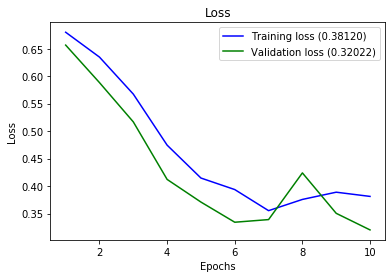

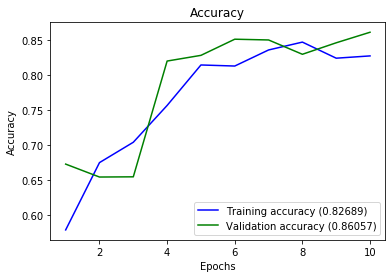

In [24]:
model.save("{}/model/final_model.h5".format(path))
plot_history(m_history)

#### Do prediction

In [25]:
# # predict for one sample
# f_pc_test = dls.process_pc(test_set["pc"][0:1], lambda x: _get_features(x))
# f_pc_test = np.expand_dims(f_pc_test[0], axis=0)
# res_test = model.predict(f_pc_test, verbose=1).squeeze()
# plot([[res_test[:, : , 0]]])

In [26]:
def get_prediction(model, features):
    '''
    Get prediction for a given model and point cloud.
    '''
    # f = _get_features(points)
    f = np.expand_dims(features, axis=0)
    return model.predict(f, verbose=0).squeeze()

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f83c40e1710>]]

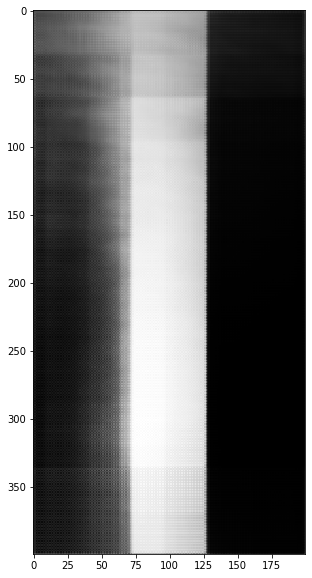

In [27]:
points = dls.process_pc(test_set["pc"][0:1], lambda x:x)[0]
features = _get_features(points)
res = get_prediction(model, features)
plot([[res[:, : ,0]]])

In [28]:
def apply_threshold(res, threshold=0.9):
    '''
    Apply thresholding on probability values.
    '''
    _tmp = res.copy()
    _tmp[res >= threshold] = 1
    _tmp[res < threshold] = 0
    return _tmp.astype(np.uint8)

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f83a464fe80>]]

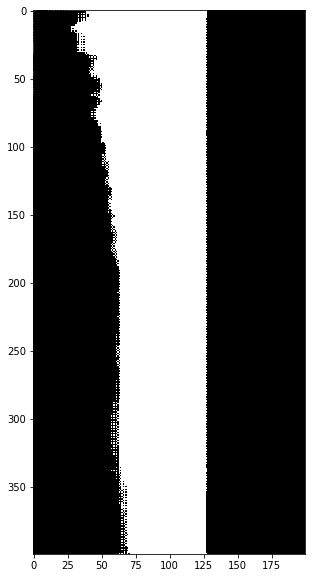

In [29]:
THRESHOLD = 0.4
plot([[apply_threshold(res, THRESHOLD)[:, : ,0]]])

In [80]:
def get_metrics_count(pred, gt):
    '''
    Get true positive, true negative, false positive, false negative counts
    '''
    diff = pred - gt
    # get tp, tn, fp, fn
    fn = diff[diff==-1].size
    fp = diff[diff==1].size
    tp = diff[gt==1].size - fn
    tn = diff[diff==0].size - tp
    return fn, fp, tp, tn

def get_metrics(pred, gt, sklearn_flag):
    '''
    Get true positive, true negative, false positive, false negative counts
    
    recall = true positives/(true positives + false negatives)
    recall = road pixels correctly classified/(road pixels correctly classified + road pixels incorrectly classified as non-road)
    
    precision = true positives/(true positives + fasle positives)
    precision = road pixels correctly classified/(road pixels correctly classified + non road incorrectly classified as road)
    
    F1/2 = (precision * recall)/(precision + recall)
    '''
    if sklearn_flag:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        acc = accuracy_score(gt, pred)
        recall = recall_score(gt, pred, average='micro')
        precision = precision_score(gt, pred, average='micro')
        f1 = f1_score(gt, pred, average='micro')
    else:
        eps = np.finfo(np.float32).eps
        fn, fp, tp, tn = get_metrics_count(pred, gt)
        acc = (tp+tn)/(tp+fp+tn+fn + eps)
        recall = tp/(tp + fn + eps)
        precision = tp/(tp + fp + eps)
        f1 = 2*((precision * recall)/(precision + recall))
    return f1, recall, precision, acc 


In [81]:
def get_output(path, model, dataset, threshold, is_viz=False, sklearn_flag=False):
    result_path = "{}/output/*".format(path)
    os.makedirs(os.path.dirname(result_path), exist_ok=True)
    # NOTE: Now computing for 8 samples (can this be done on samples from the train and validation set?)
    f = dls.process_pc(dataset["pc"][0:8], lambda x: _get_features(x))
    gt = dls.process_img(dataset["gt_bev"][0:8], func=lambda x: kitti_gt(x))
    F1, P, R, ACC = [], [], [], []
    FN, FP, TP, TN = [], [], [], []
    counter = 0
    diplay_thresh = 3
    display = []
    labels = []
    
    for i, datum in enumerate(zip(f, gt)):
        _f, _gt = datum
        res = get_prediction(model, _f)
        th_res = apply_threshold(res, threshold=threshold)
               
        # get metrics
        p_road = th_res[:, :, 0]
        gt_road = _gt[:, :, 0]
        fn, fp, tp, tn = get_metrics_count(pred=p_road, gt=gt_road)
        #used sklearn metrics to calculate the same using sklearn_flag=True
        f1, recall, precision, acc = get_metrics(gt=gt_road, pred=p_road, sklearn_flag=sklearn_flag)
        F1.append(f1)
        P.append(precision)
        R.append(recall)
        ACC.append(acc)
        TP.append(tp)
        FP.append(fp)
        TN.append(tn)
        FN.append(fn)
        
        # for viz
        if is_viz is True:
            display.append([gt_road, res[:,:,0], p_road])
            labels.append(["gt", "Acc: {}".format(str(np.round(acc,2))), "F1: {}".format(str(np.round(f1,2)))])
            if (i+1) % diplay_thresh == 0:
                plot(display, labels, fontsize=10)
                plt.savefig(result_path.replace("*", str(i+1) + ".jpg"))
                display, labels = [], []
    if is_viz is True:
        plot(display, labels, fontsize=10)
        plt.savefig(result_path.replace("*", str(i+1) + ".jpg"))
    
    eps = np.finfo(np.float32).eps        
    _acc = (sum(TP)+sum(TN))/(sum(TP)+sum(FP)+sum(TN)+sum(FN) + eps)
    _recall = sum(TP)/(sum(TP) + sum(FN)+eps)
    _precision = sum(TP)/(sum(TP) + sum(FP)+eps)
    _f1 = 2*((precision * recall)/(precision + recall))    
    return _acc, _recall, _precision, _f1

0.8350906249998444 0.9506740069967414 0.6581922715223332 0.849904893650309


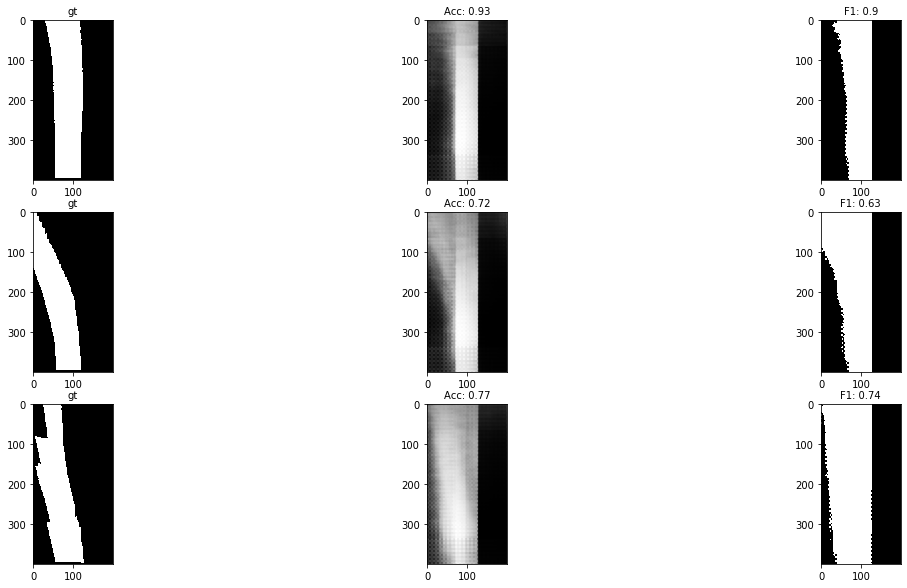

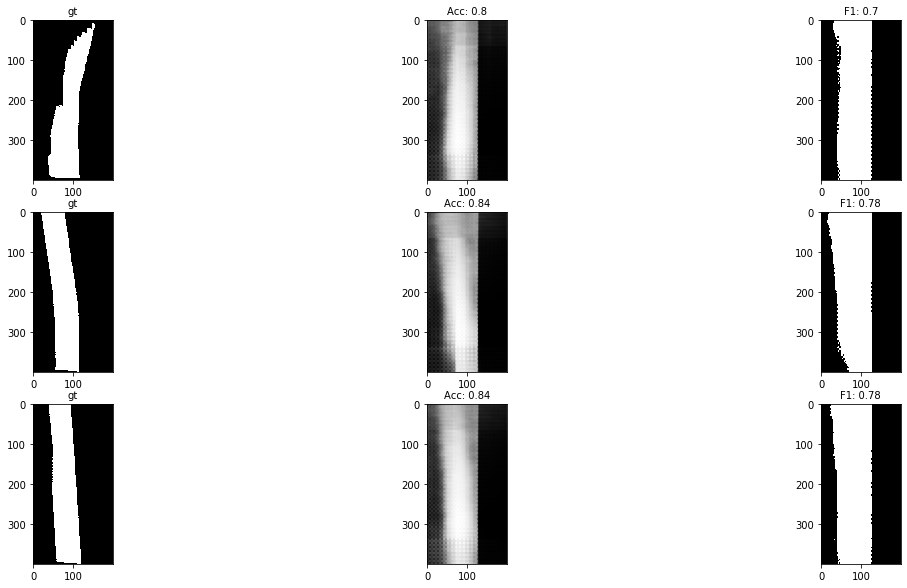

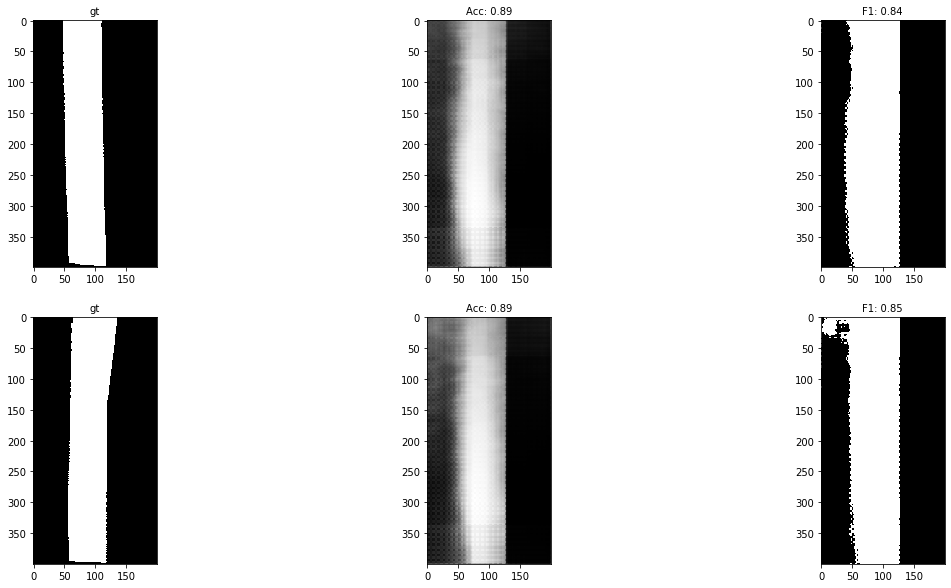

In [82]:
_acc, _recall, _precision, _f1 = get_output(path, model, test_set, threshold=THRESHOLD, is_viz=True, sklearn_flag=False)
print(_acc, _recall, _precision, _f1)

0.8350906249998444 0.9506740069967414 0.6581922715223332 0.8499048936538129


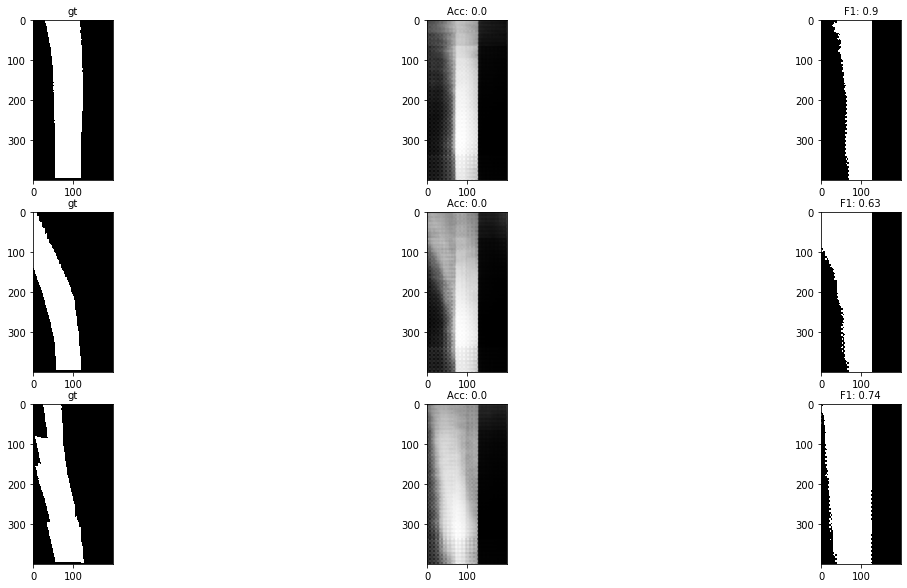

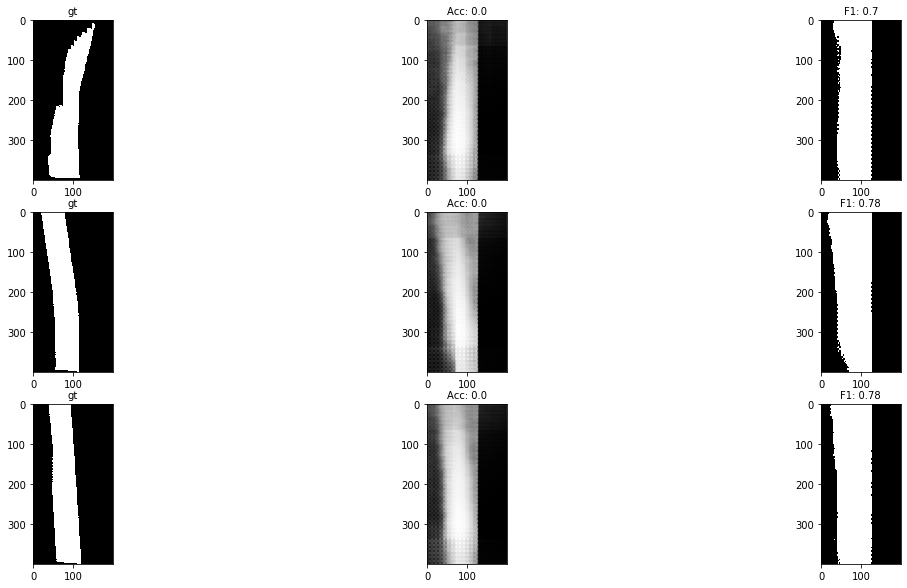

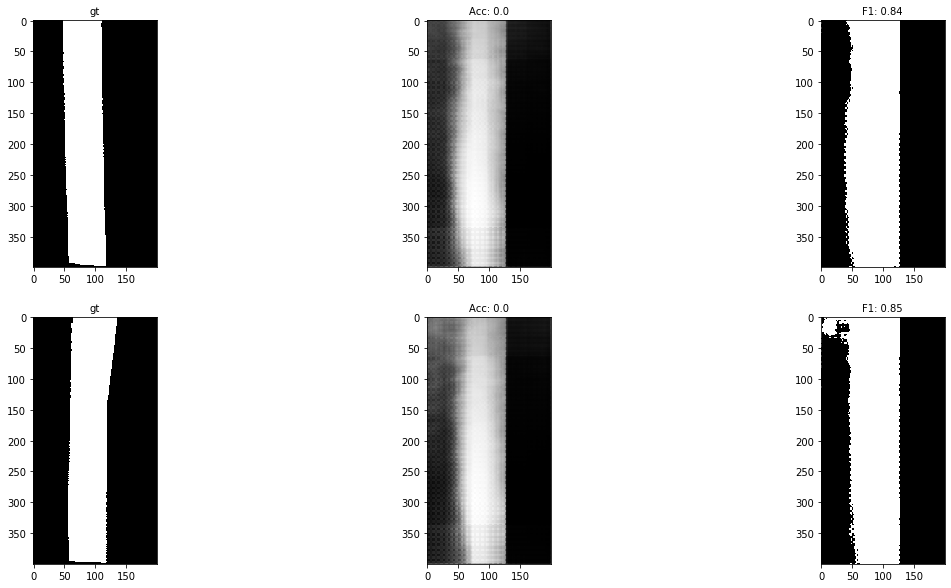

In [83]:
_acc, _recall, _precision, _f1 = get_output(path, model, test_set, threshold=THRESHOLD, is_viz=True, sklearn_flag=True)
print(_acc, _recall, _precision, _f1)

In [84]:
details = {"name" : _NAME,
           "run_id" : run_id,
           "dataset": "KITTI",
           "training_config" : training_config,
           "threshold" : THRESHOLD,
           "accuracy" : _acc,
           "recall" : _recall,
           "precision" : _precision,
           "F1" : _f1}

In [85]:
with open('{}/details.json'.format(path), 'w') as f:
    json.dump(details, f)